# VRAM REQUIREMENTS
This notebook is quite intense... If you are running on GPU i recommend at least 8GB of VRAM, if you are having trouble running this, you can reduce the size of the models, and the sequence lengths, but scaling down may reduce KV cache effectiveness and thus make the demo meaningless

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")

torch.manual_seed(1337)

In [2]:
sequence_length = 4096

class Attention(nn.Module):
    def __init__(self, emb_size, head_size):
        super().__init__()
        self.emb_size = emb_size
        self.head_size = head_size

        self.keys = nn.Linear(emb_size, head_size, bias=False)
        self.queries = nn.Linear(emb_size, head_size, bias=False)
        self.values = nn.Linear(emb_size, head_size, bias=False)

        self.register_buffer("tril", torch.tril(torch.ones(sequence_length, sequence_length)))

    def forward(self, x):
        keys = self.keys(x)
        queries = self.queries(x)
        values = self.values(x)
        
        tril = self.tril[:x.size(1), :x.size(1)]
        weights = queries @ keys.transpose(-2, -1) * (self.head_size ** -0.5)
        weights = weights.masked_fill(tril == 0, float("-inf"))
        weights = F.softmax(weights, dim=-1)
        
        return weights @ values
    
    def autoregressive_forward(self, x):
        keys = self.keys(x)
        query = self.queries(x[:, -1])
        values = self.values(x)

        weights = query @ keys.transpose(-2, -1) * (self.head_size ** -0.5)
        weights = F.softmax(weights, dim=-1)
        
        return weights @ values

DIM = 1024
att = Attention(emb_size=DIM, head_size=DIM).to(device)
torch.cuda.synchronize() 


In [3]:
with torch.no_grad():

    # ----- Testing correctness ------
    
    # Random data for testing
    x = torch.randn(1, 5, DIM).to(device)
    y = x[:, :x.size(1)-1]

    # Compute the cache and do an autoregressive step
    att.forward(y)
    a = att.autoregressive_forward(x)

    # Compute the forward pass without the cache for comparison
    b = att.forward(x)[:, -1]
    print("Correct cached pass" if ((a - b < 1e-3).sum(-1)/a.numel()).item() == 1.0 else "Incorrect cached forward pass (try rerunning to check for randomn errors)")



    # ----- Testing speed ------

    x = torch.randn(1, 128, DIM).to(device)

    # --> Basic Attention
    start_time = time.time()
    for i in range(800):
        next = att.forward(x)[:, -1].unsqueeze(1)
        x = torch.cat([x, next], dim=1)
    print(f"Time taken: {time.time() - start_time} seconds")

    # --> Autoregressive Attention
    x = x[:, :128]
    start_time = time.time()
    for i in range(800):
        next = att.autoregressive_forward(x)
        x = torch.cat([x, next], dim=1)
    print(f"Time taken: {time.time() - start_time} seconds")

Correct cached pass
Time taken: 0.552377462387085 seconds
Time taken: 0.34394216537475586 seconds


In [4]:

class CachedAttention(nn.Module):
    def __init__(self, emb_size, head_size):
        super().__init__()
        self.emb_size = emb_size
        self.head_size = head_size

        self.keys = nn.Linear(emb_size, head_size, bias=False)
        self.queries = nn.Linear(emb_size, head_size, bias=False)
        self.values = nn.Linear(emb_size, head_size, bias=False)

        self.register_buffer("tril", torch.tril(torch.ones(sequence_length, sequence_length)))
        self.register_buffer("key_cache", torch.zeros(1, sequence_length, head_size))
        self.register_buffer("value_cache", torch.zeros(1, sequence_length, head_size))

    def forward(self, x, store_cache=False):
        keys = self.keys(x)
        queries = self.queries(x)
        values = self.values(x)
        
        tril = self.tril[:x.size(1), :x.size(1)]
        weights = queries @ keys.transpose(-2, -1) * (self.head_size ** -0.5)
        weights = weights.masked_fill(tril == 0, float("-inf"))
        weights = F.softmax(weights, dim=-1)

        if store_cache:
            self.key_cache[:, :x.size(1)] = keys
            self.value_cache[:, :x.size(1)] = values
        
        return weights @ values
    
    def cached_autoregressive_forward(self, x):
        last_token = x[:, -1:]
        new_keys = self.keys(last_token)
        new_queries = self.queries(last_token)
        new_values = self.values(last_token)
        L = x.size(1)-1

        self.key_cache[:, L, :] = new_keys
        self.value_cache[:, L, :] = new_values

        weights = new_queries @ self.key_cache[:, :L+1, :].transpose(-2, -1) * (self.head_size ** -0.5)
        weights = F.softmax(weights, dim=-1)
        return weights @ self.value_cache[:, :L+1, :]

att_cached = CachedAttention(emb_size=DIM, head_size=DIM).to(device)
torch.cuda.synchronize() 

In [5]:
with torch.no_grad():
        
    # Random data for testing
    x = torch.randn(1, 20, DIM).to(device)
    y = x[:, :x.size(1)-1]

    # Compute the cache and do an autoregressive step
    att_cached.forward(y, store_cache=True)
    a = att_cached.cached_autoregressive_forward(x)

    # Compute the forward pass without the cache for comparison
    b = att_cached.forward(x)[:, -1]
    print("Correct cached pass" if ((a - b < 1e-3).sum(-1)/a.numel()).item() == 1.0 else "Incorrect cached forward pass (try rerunning to check for randomn errors)")


    # Now that we checked for correctness, we can try testing speed
    S = 1024
    N = sequence_length-S
    x = torch.randn(1, S, DIM).to(device)
    start_time = time.time()
    for i in range(N):
        next = att_cached.forward(x)[:, -1].unsqueeze(1)
        x = torch.cat([x, next], dim=1)
    print(x.shape)
    print(f"Time taken: {time.time() - start_time} seconds")

    # Now we can try the autoregressive forward pass from the old implementation of att
    x = x[:, :S]
    start_time = time.time()
    for i in range(N):
        next = att.autoregressive_forward(x)
        x = torch.cat([x, next], dim=1)

    print(f"Time taken: {time.time() - start_time} seconds")

    # Now we can try the autoregressive cached forward pass
    x = x[:, :S]
    start_time = time.time()
    for i in range(N):
        next = att_cached.cached_autoregressive_forward(x)
        x = torch.cat([x, next], dim=1)

    print(f"Time taken: {time.time() - start_time} seconds")
    print(f"Size in RAM of the KV cache: {att_cached.key_cache.numel() * att_cached.key_cache.element_size() * 4 / 1024 / 1024} MB")
    print(f"Size in RAM of the Attention matrix: {sequence_length * att.emb_size ** 2 * 4 / 1024 / 1024} MB")

Correct cached pass


torch.Size([1, 4096, 1024])
Time taken: 12.524032354354858 seconds
Time taken: 3.7176151275634766 seconds
Time taken: 1.8234357833862305 seconds
Size in RAM of the KV cache: 64.0 MB
Size in RAM of the Attention matrix: 16384.0 MB


In [6]:
with open("datasets/enwik8", "r") as f:
    load = f.read()[:1000000] # Limited for testing
print(load[:200])

<mediawiki xmlns="http://www.mediawiki.org/xml/export-0.3/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.mediawiki.org/xml/export-0.3/ http://www.mediawiki.org/


In [7]:
class MyInputs:
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.data) - self.sequence_length
        
    def __getitem__(self, idx):
        start_indices = idx.unsqueeze(1) + torch.arange(self.sequence_length)
        return self.data[start_indices]


In [8]:
# Restricting to ASCII characters
texttoint = {chr(i): i for i in range(256)}
inttotext = {i: chr(i) for i in range(256)}
dataset = torch.tensor([texttoint[c] for c in load if c in texttoint])

vocab_size = len(texttoint)
sequence_length = 20
val_set = int(len(dataset)*0.1)

inputs = MyInputs(dataset[val_set:-1-sequence_length], sequence_length)
labels = MyInputs(dataset[val_set+1:-sequence_length], sequence_length)
val_inputs = MyInputs(dataset[:val_set], sequence_length)
val_labels = MyInputs(dataset[1:val_set+1], sequence_length)

print(len(dataset))

997275


In [9]:
import math

class FullyConnected(nn.Module):  
    def __init__(self, in_size, out_size, hidden_size, n_layers):
        super(FullyConnected, self).__init__()

        self.fc1 = nn.Linear(in_size, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)])
        self.fc2 = nn.Linear(hidden_size, out_size)
    
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        for fc in self.fcx:
            x = F.gelu(fc(x))
        x = self.fc2(x)
        return x

class Attention(nn.Module):
    """Fixed-size (2048) KV cache.  Refill at training-time, append at eval-time."""
    def __init__(self, emb_size: int, cache_len):
        super().__init__()
        self.emb_size  = emb_size
        self.cache_len = cache_len

        self.keys    = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values  = nn.Linear(emb_size, emb_size)

        self.register_buffer("cache_k",  torch.zeros(1, cache_len, emb_size))
        self.register_buffer("cache_v",  torch.zeros(1, cache_len, emb_size))
        self.step = 0 

    def forward(self, x, autoregressive=False):
        if autoregressive:   
            qk, v = self.update_qkv(x) # inference
        else:
            qk, v = self.compute_qkv(x) # training 

        att = torch.softmax(qk / math.sqrt(self.emb_size), dim=-1)
        return torch.matmul(att, v)

    def compute_qkv(self, x, build_cache=False):
        q, k, v = self.queries(x), self.keys(x), self.values(x)

        if build_cache:
            L = x.shape[1]
            self.cache_k[:, :L, :]   = k
            self.cache_v[:, :L, :]   = v
            self.step = L
            
        qk = torch.matmul(q, k.transpose(-2, -1))
        tril = torch.tril(torch.ones(x.shape[1], x.shape[1], device=x.device, dtype=torch.bool))
        qk = qk.masked_fill(tril == 0, float("-inf"))
        return qk, v

    def update_qkv(self, x):
        assert x.shape[0] == 1, "Only batch size 1 is supported"
        if self.step == 0: print("Prefill"); return self.compute_qkv(x, build_cache=True)
        
        last_token = x[:, -1, :]
        q = self.queries(last_token).unsqueeze(1)
        k = self.keys(last_token).unsqueeze(1)
        v = self.values(last_token).unsqueeze(1)

        self.cache_k[:, self.step:self.step+1, :] = k
        self.cache_v[:, self.step:self.step+1, :] = v

        self.step += 1
        qk = torch.matmul(q, self.cache_k[:, :self.step, :].transpose(-2, -1))
        return qk, self.cache_v[:, :self.step, :]

class Block(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers, cache_len):
        super().__init__()
        self.prenorm1 = nn.LayerNorm(emb_size)
        self.att      = Attention(emb_size, cache_len)
        self.prenorm2 = nn.LayerNorm(emb_size)
        self.fc       = FullyConnected(emb_size, emb_size, hidden_size, n_layers)

    def forward(self, x, **kwargs):
        x = x + self.att(self.prenorm1(x), **kwargs)
        x = x + self.fc(self.prenorm2(x))
        return x

class Transformer(nn.Module):
    def __init__(self, vocab_size, emb_size, n_blocks,
                 head_size, hidden_size, n_layers, sequence_length, cache_len):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.posemb    = nn.Embedding(sequence_length, emb_size)
        self.blocks    = nn.ModuleList([Block(emb_size, hidden_size, n_layers, cache_len) for _ in range(n_blocks)])
        self.out = nn.Linear(emb_size, vocab_size)

    def forward(self, x, **kwargs):
        x = self.embedding(x) + self.posemb(torch.arange(x.size(1), device=x.device))

        if kwargs.get("autoregressive", False) and self.blocks[-1].att.step != 0: 
            x = x[:, -1:] # We select the last token after positional encodings 
        for block in self.blocks:
            x = block(x, **kwargs)
        return self.out(x)
    
    def reset_cache(self):
        for block in self.blocks:
            block.att.step = 0
    
DIM = 1024
model = Transformer(vocab_size=len(inttotext), emb_size=DIM, n_blocks=4, head_size=DIM, hidden_size=DIM, n_layers=2, sequence_length=2048, cache_len=2048).to(device)


Millions of parameters: 32.03
Step ___0 - Loss: 5.889 - Val Loss: 4.475
Step __25 - Loss: 2.666 - Val Loss: 2.652
Step __50 - Loss: 2.366 - Val Loss: 2.419
Step __75 - Loss: 2.168 - Val Loss: 2.218
Step _100 - Loss: 2.083 - Val Loss: 2.212
Step _125 - Loss: 2.020 - Val Loss: 2.079
Step _150 - Loss: 1.927 - Val Loss: 1.967
Step _175 - Loss: 1.883 - Val Loss: 1.991
Step _200 - Loss: 1.834 - Val Loss: 1.930
Step _225 - Loss: 1.766 - Val Loss: 1.863


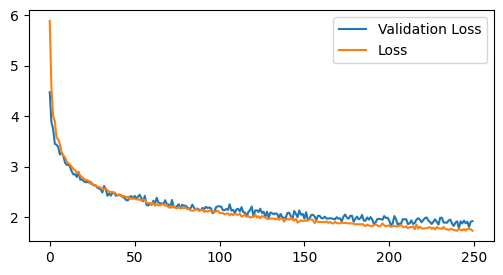

In [10]:
#torch.compile(model)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

batch_size = 1024
steps = 250
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for step in range(steps):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device), autoregressive=False) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred.view(-1, vocab_size), labels[indexes].to(device).view(-1))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    with torch.no_grad():
        indexes = torch.randint(0, len(val_inputs), (batch_size//8,))
        pred = model(val_inputs[indexes].to(device))

        loss = F.cross_entropy(pred.view(-1, vocab_size), val_labels[indexes].to(device).view(-1))
        vlossi.append(loss.item())

    if step % (steps//10) == 0:
        print(f"Step {step:_>4d} - Loss: {lossi[-1]:.3f} - Val Loss: {vlossi[-1]:.3f}")
    
plt.figure(figsize=(6, 3))
plt.plot(vlossi[:], label='Validation Loss')
plt.plot(lossi[:], label='Loss')
plt.legend()

In [11]:
model.reset_cache()
example = inputs[torch.zeros(1).long()].to(device)
print(example)

with torch.no_grad():
    for i in range(2000):
        next = model.forward(example, autoregressive=True)[:, -1]
        example = torch.cat([example, next.argmax(dim=-1).unsqueeze(1)], dim=1)

print("".join(inttotext[i.item()] for i in example[0])[:20])
print("".join(inttotext[i.item()] for i in example[0])[20:])

tensor([[119, 104, 111,  32, 115, 101, 101, 107,  32,  97,  32,  99, 117, 114,
         101,  32, 102, 111, 114,  32]], device='cuda:0')
Prefill
Prefill
Prefill
Prefill


who seek a cure for 
trmelllivenedorcrevesimbexupalimanalusimevevesendermeresexededoredexexellimasesinedelousedevedusimenallinesustrmatimendesevedendex helousimomedededenedesinalorve fffesusedex tormendededelumeredenoustigusimendedenenene thedededomalormelorededededendededeximededesedenesusevenenetre thedex thanedededenesedevethedenedene trmedendenalormededenedede thastomene sthalomededoususenamenexigusimedenatededimedede thasustedededenususimededomareximbededededede trevesthaloumedevedesendedededededenedenededededenededimedededededex.usususususesimendedemasenenededendesedededelloustedenestrmbe asthalovedesusimathase imandedemesigustorenedenusededede thaloredededoumenedestedededelormalothimededededene timenasede (sedederededene igusededededededenedede irvededededededederededelivedededede te chimaloredede sedesumedededededenesigusistysederme thimedenedede tredededesedeshalmede hasphalededesigusivede (simedede thimasivedededowsesedededesthasesedede himenededesusimededesushasenedededene t

-> Note: You see many prefills, because we have one for each attention layer

In [12]:
example = inputs[torch.zeros(1).long()].to(device)
print(example)

with torch.no_grad():
    for i in range(2000):
        next = model.forward(example, autoregressive=False)[:, -1]
        example = torch.cat([example, next.argmax(dim=-1).unsqueeze(1)], dim=1)

print("".join(inttotext[i.item()] for i in example[0])[:20])
print("".join(inttotext[i.item()] for i in example[0])[20:])

tensor([[119, 104, 111,  32, 115, 101, 101, 107,  32,  97,  32,  99, 117, 114,
         101,  32, 102, 111, 114,  32]], device='cuda:0')


who seek a cure for 
trmelllivenedorcrevesimbexupalimanalusimevevesendermeresexededoredexexellimasesinedelousedevedusimenallinesustrmatimendesevedendex helousimomedededenedesinalorve fffesusedex tormendededelumeredenoustigusimendedenenene thedededomalormelorededededendededeximededesedenesusevenenetre thedex thanedededenesedevethedenedene trmedendenalormededenedede thastomene sthalomededoususenamenexigusimedenatededimedede thasustedededenususimededomareximbededededede trevesthaloumedevedesendedededededenedenededededenededimedededededex.usususususesimendedemasenenededendesedededelloustedenestrmbe asthalovedesusimathase imandedemesigustorenedenusededede thaloredededoumenedestedededelormalothimededededene timenasede (sedederededene igusededededededenedede irvededededededederededelivedededede te chimaloredede sedesumedededededenesigusistysederme thimedenedede tredededesedeshalmede hasphalededesigusivede (simedede thimasivedededowsesedededesthasesedede himenededesusimededesushasenedededene t

Prefill
Prefill
Prefill
Prefill


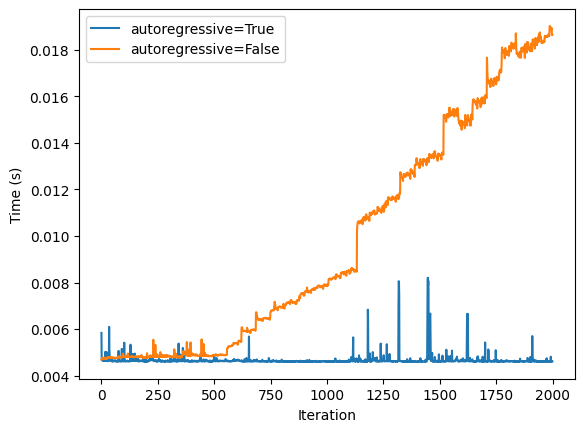

In [13]:
def bench(ar):
    ex = inputs[torch.zeros(1).long()].to(device); model.reset_cache(); t=[]
    sync = torch.cuda.synchronize if device.type=="cuda" else lambda: None
    with torch.no_grad():
        for _ in range(2000):
            sync(); t0=time.perf_counter()
            nxt = model.forward(ex, autoregressive=ar)[:, -1]
            ex = torch.cat([ex, nxt.argmax(dim=-1).unsqueeze(1)], 1)
            sync(); t.append(time.perf_counter()-t0)
    return t

t_ar, t_nar = bench(True), bench(False)
plt.plot(t_ar, label="autoregressive=True"); plt.plot(t_nar, label="autoregressive=False")
plt.xlabel("Iteration"); plt.ylabel("Time (s)"); plt.legend(); plt.show()


# O(N) vs O(1)
This really shows how having to recompute the whole Keys and Values becomes very expensive with high dimensional tensors. 
If you want to use smaller models and still see this difference, i recommend moving the models on CPU, since it's more compute bound and it will show the difference well. 